## Objective: To build a model that predicts whether the given chest_x_ray image belongs to pneuominia or not.

> ## Business Metrics:
- At any cost our model should not classify a pnuomina pateint x_ray as normal,
- So we should target very high recall rate, Also we should not loose the precision too.
- So there will always be trade off between both precission and recall, We can consider F1-score as a good metric for this problem, with special emphasize on recall rate.

In [1]:
# lets initially import the necessary libraries
import numpy as np
import pandas as pd
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from skimage import io
from numpy.random import seed
seed(64)
from tensorflow import set_random_seed
set_random_seed(64)
import sys
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import scikitplot as skplt
from keras.models import load_model
%matplotlib inline

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
print(os.listdir("/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray"))

['train', 'test', 'val', '.DS_Store']


In [3]:
# lets set the directory path so that we can use later.
dir_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray"
# lets see one of the pneumonia image from train data
os.listdir(dir_path+'/train/PNEUMONIA')[:4]

['person1669_bacteria_4423.jpeg',
 'person905_bacteria_2830.jpeg',
 'person1378_bacteria_3513.jpeg',
 'person1228_bacteria_3183.jpeg']

In [4]:
os.listdir(dir_path+'/train/NORMAL')[:4]

['NORMAL2-IM-1327-0001.jpeg',
 'NORMAL2-IM-1135-0001.jpeg',
 'IM-0566-0001.jpeg',
 'NORMAL2-IM-1002-0001.jpeg']

In [5]:
sample_pn_img = io.imread(dir_path+'/train/PNEUMONIA/person498_bacteria_2102.jpeg')
sample_nor_img = io.imread(dir_path+'/train/NORMAL/NORMAL2-IM-1051-0001.jpeg')

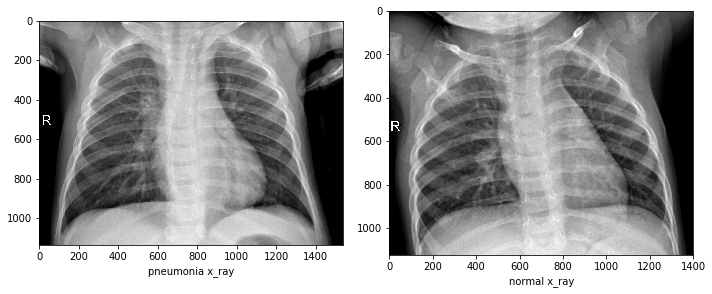

In [6]:
# lets see a pneumonia and normal x_ray
fig, ax = plt.subplots(1, 2)#, sharey=True)
fig.set_figwidth(10)
fig.set_figheight(8)
ax[0].imshow(sample_pn_img, cmap='gray');
ax[0].set_xlabel("pneumonia x_ray")
ax[1].imshow(sample_nor_img, cmap='gray');
ax[1].set_xlabel('normal x_ray')
plt.tight_layout()
plt.show()

## DATA PREPARATION:
## Lets progressively load the train, validation and test data using the ImageDataGenerator of keras.

In [7]:
# Lets initiate the imagedatagenerator
train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                            shear_range = 0.2,
                            zoom_range = 0.2,
                            horizontal_flip = True,
                            rotation_range=10)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [8]:
# we will use .flow_from_directory() to generate batches of images data instead of loading them manually
batch_size = 16
train_generator = train_datagen.flow_from_directory(dir_path+'/train', batch_size=batch_size, class_mode='binary')
valid_generator = test_datagen.flow_from_directory(dir_path+'/val', batch_size=batch_size, class_mode='binary')
test_generator = test_datagen.flow_from_directory(dir_path+'/test', batch_size=batch_size, class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


- From above we can see:
- There are total 5216 images in training data.
- There are total 16 images in validation data which is low.
- There are total 624 images in the testing data.

In [9]:
train_len = 5216
val_len = 16
test_len = 624

In [10]:
train_generator.reset()
batchX, batchY = train_generator.next()
print(batchX.shape)
print(batchY.shape)
print(np.unique(batchY))
train_generator.class_indices

(16, 256, 256, 3)
(16,)
[0. 1.]


{'NORMAL': 0, 'PNEUMONIA': 1}

- As we can see from above:
- the first batch of training data contains total 16 images with 256 by 256 size
- Also the batchY have only 0 and 1 values in which:
    - 0 represents Normal
    - 1 represents PNEUMONIA according to there alphebatical orders(keras conventions)

# Base Model:

- Lets create a baseline model first and then improve our architecture based on the results of baseline model.
- As CNN works best on image data, we will build a very basic CNN model and will improve upon that.
- Lets also try a pretrained network all vgg16 and see whether we require the pretrained model for this problem.

In [11]:
# lets first import all the necessary libraries
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping

In [12]:
# lets build very basic model
def def_model():
    
    model = Sequential()
    model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', input_shape=(256, 256, 3)))
    model.add(MaxPool2D((2,2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [13]:
# lets compile our model
model = def_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 516128)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               51612900  
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 51,613,897
Trainable params: 51,613,897
Non-trainable params: 0
_________________________________________________________________


In [14]:
# lets train our model now:
early_stopping_monitor = EarlyStopping(patience=2) 
history = model.fit_generator(train_generator, steps_per_epoch=train_len//batch_size,\
                    epochs=100, validation_data=valid_generator,\
                   validation_steps=val_len//batch_size,\
                   callbacks = [early_stopping_monitor])
model.save_weights('first_try.h5')

Epoch 1/100
326/326 [==============================] - 141s 434ms/step - loss: 4.1064 - acc: 0.7421 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 2/100
326/326 [==============================] - 118s 363ms/step - loss: 4.0895 - acc: 0.7435 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 3/100
326/326 [==============================] - 119s 365ms/step - loss: 4.1048 - acc: 0.7425 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 4/100
326/326 [==============================] - 119s 365ms/step - loss: 4.1079 - acc: 0.7423 - val_loss: 7.9712 - val_acc: 0.5000


In [15]:
def model_plots(history):
    # plot loss
    fig, ax = plt.subplots(1, 2);
    fig.set_figwidth(12);
    fig.set_figheight(6);
    
    ax[0].plot(history.history['loss'], color='blue', label='train');
    ax[0].plot(history.history['val_loss'], color='orange', label='val');
    ax[0].set_xlabel('epochs');
    ax[0].set_title("cross entropy loss");
    ax[0].legend();
    # plot accuracy
    
    ax[1].plot(history.history['acc'], color='blue', label='train');
    ax[1].plot(history.history['val_acc'], color='orange', label='val');
    ax[1].set_xlabel('epochs');
    ax[1].set_title('Classification Accuracy');
    ax[1].legend();
    plt.tight_layout();
    plt.show();
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    plt.savefig(filename + '_plot.png');

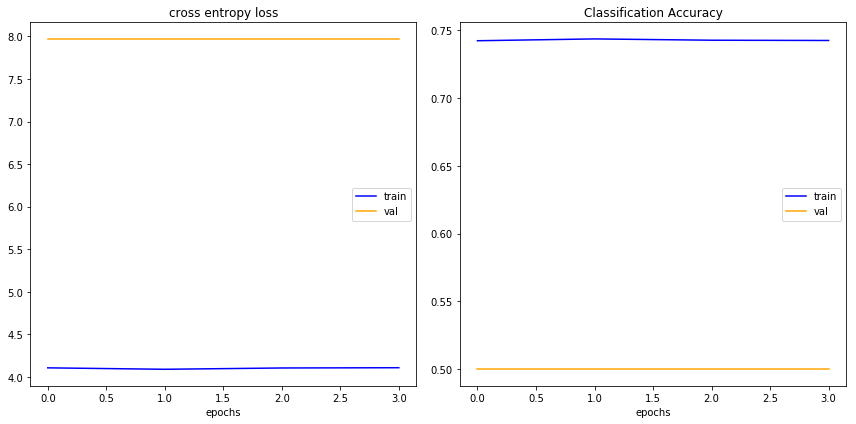

<Figure size 432x288 with 0 Axes>

In [16]:
model_plots(history)

- As we can see with this simple model we are getting validation accuracy of 0.5 and train accuracy of 0.7433
- Lets try to improve our model further and lets see whether it improves or not.

- From above we can see our model is not improving over epochs and also we have a classimbalance here
- Lets take care of class imbalance first before trying to improve our model.

In [17]:
from sklearn.utils import class_weight
train_labels = train_generator.labels
unique_labels = np.unique(train_labels)

Text(0.5, 1.0, 'number of pneumonia and normal cases')

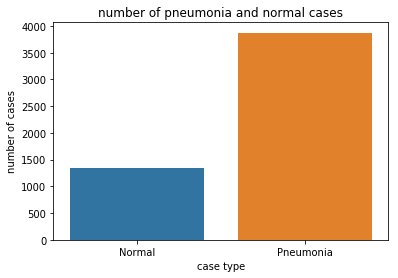

In [18]:
sns.countplot(train_labels);
plt.xlabel('case type');
plt.ylabel('number of cases');
plt.xticks((0,1), ('Normal', 'Pneumonia'));
plt.title('number of pneumonia and normal cases')

- As we can number of pneumonia x_rays are more than normal x_rays.
- Lets solve the class imbalance problem by associating respective class weights.

In [19]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 unique_labels,
                                                 train_labels)
class_weight_dict = dict(enumerate(class_weights))

In [20]:
class_weight_dict

{0: 1.9448173005219984, 1: 0.6730322580645162}

- Now we have class_weights which we can use while trianing our models.
- Lets improve our architecture.

In [21]:
from keras.optimizers import adam

In [22]:
#lets change our model and see if it improves
def three_conv_model():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(64, 64, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = adam(lr=0.001)#momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 516128)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               51612900  
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 51,613,897
Trainable params: 51,613,897
Non-trainable params: 0
_________________________________________________________________


In [24]:
batch_size = 16
train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                            shear_range = 0.2,
                            zoom_range = 0.2,
                            horizontal_flip = True,
                            rotation_range=10)
test_datagen = ImageDataGenerator(rescale = 1./255)
# we will use .flow_from_directory() to generate batches of images data instead of loading them manually
batch_size = 16
train_generator = train_datagen.flow_from_directory(dir_path+'/train', batch_size=batch_size,\
                                              class_mode='binary', target_size=(64, 64))
valid_generator = test_datagen.flow_from_directory(dir_path+'/val', batch_size=batch_size,\
                                              class_mode='binary', target_size=(64, 64))
test_generator = test_datagen.flow_from_directory(dir_path+'/test', batch_size=batch_size,\
                                             class_mode='binary', target_size=(64, 64))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [25]:
mul_conv_model = three_conv_model()
early_stopping_monitor = EarlyStopping(patience=5) 
mul_conv_history = mul_conv_model.fit_generator(train_generator, steps_per_epoch=train_len//batch_size,\
                    epochs=100, validation_data=valid_generator,\
                   validation_steps=val_len//batch_size,\
                   callbacks = [early_stopping_monitor],\
                   class_weight=class_weight_dict)

Epoch 1/100
326/326 [==============================] - 62s 189ms/step - loss: 0.4384 - acc: 0.8046 - val_loss: 0.4044 - val_acc: 0.8125
Epoch 2/100
326/326 [==============================] - 61s 189ms/step - loss: 0.2303 - acc: 0.9047 - val_loss: 0.5704 - val_acc: 0.5625
Epoch 3/100
326/326 [==============================] - 61s 186ms/step - loss: 0.1944 - acc: 0.9187 - val_loss: 0.4543 - val_acc: 0.8125
Epoch 4/100
326/326 [==============================] - 61s 187ms/step - loss: 0.1699 - acc: 0.9293 - val_loss: 0.5467 - val_acc: 0.7500
Epoch 5/100
326/326 [==============================] - 61s 186ms/step - loss: 0.1746 - acc: 0.9300 - val_loss: 0.6365 - val_acc: 0.7500
Epoch 6/100
326/326 [==============================] - 60s 185ms/step - loss: 0.1729 - acc: 0.9331 - val_loss: 0.3784 - val_acc: 0.8125
Epoch 7/100
326/326 [==============================] - 61s 187ms/step - loss: 0.1583 - acc: 0.9406 - val_loss: 0.4096 - val_acc: 0.7500
Epoch 8/100
326/326 [===========================

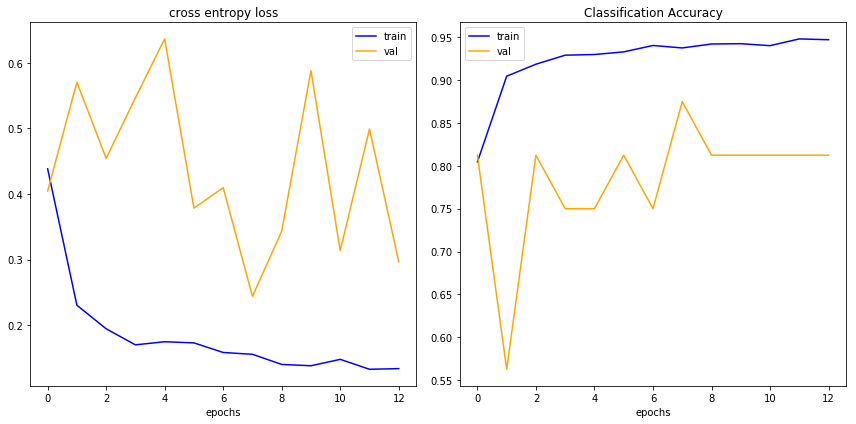

<Figure size 432x288 with 0 Axes>

In [26]:
model_plots(mul_conv_history)

- We can see our model learning and also our validation accuracy varied between 0.62 to 0.93
- Although thats not a great valdation accuracy but definitely better than our base line model
- Lets now evalute our model on test data.

In [27]:
test_loss, acc = mul_conv_model.evaluate_generator(test_generator, steps=len(test_generator))
print(f'accuracy on test data using multiple convolution neural networks is {acc * 100.0}%')
print(f'test loss on test data using multiple convolution neural networks is {test_loss}')

accuracy on test data using multiple convolution neural networks is 91.50641025641025%
test loss on test data using multiple convolution neural networks is 0.2917544427208411


- We are getting accuracy of 92.14% which is good for start

## Lets try using pretrained vgg16 model now.

In [28]:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.optimizers import SGD, Nadam
from keras.models import Model

In [29]:
def define_vggmodel():
    # load model
    model = VGG16(include_top=False, input_shape=(64, 64, 3))
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(1, activation='sigmoid')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [30]:
vgg_model = define_vggmodel()
vgg_early_stopping_monitor = EarlyStopping(patience=3) 
vgg_history = vgg_model.fit_generator(train_generator, steps_per_epoch=train_len//batch_size,\
                    epochs=100, validation_data=valid_generator,\
                   validation_steps=val_len//batch_size,\
                   callbacks = [vgg_early_stopping_monitor],\
                   class_weight=class_weight_dict)

58892288/58889256 [==============================] - 5s 0us/step
Epoch 1/100
326/326 [==============================] - 62s 190ms/step - loss: 0.4150 - acc: 0.8196 - val_loss: 0.2520 - val_acc: 0.9375
Epoch 2/100
326/326 [==============================] - 60s 184ms/step - loss: 0.2813 - acc: 0.8840 - val_loss: 0.1948 - val_acc: 0.9375
Epoch 3/100
326/326 [==============================] - 61s 186ms/step - loss: 0.2491 - acc: 0.8978 - val_loss: 0.2018 - val_acc: 0.9375
Epoch 4/100
326/326 [==============================] - 61s 188ms/step - loss: 0.2307 - acc: 0.9036 - val_loss: 0.2142 - val_acc: 0.9375
Epoch 5/100
326/326 [==============================] - 61s 186ms/step - loss: 0.2320 - acc: 0.9055 - val_loss: 0.2120 - val_acc: 0.9375


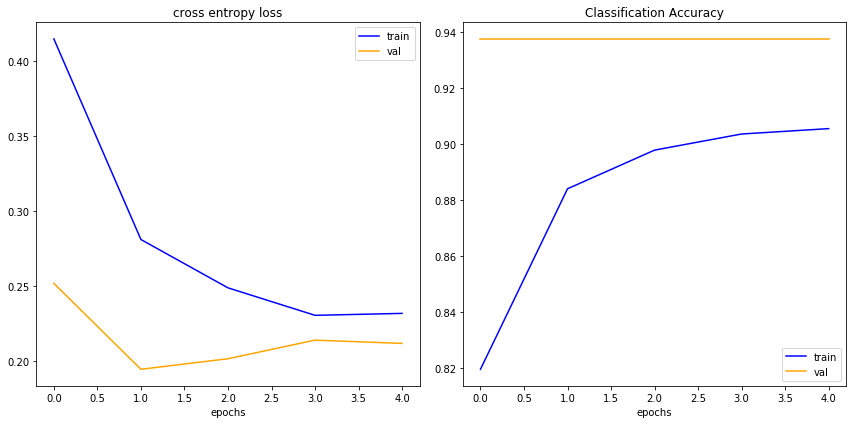

<Figure size 432x288 with 0 Axes>

In [31]:
model_plots(vgg_history)

- With vgg16 we got good results, we achieved good validation accuracy of 0.9375 in the inital epochs itself but sadly it didn't improve after that.
- It seems we further training the initial layers of vgg we can improve our model further.
- Lets evaluate our vgg model on test data.

In [32]:
test_loss, acc = vgg_model.evaluate_generator(test_generator, steps=len(test_generator))
print(f'accuracy on test data using vggmodel is {acc * 100.0}%')
print(f'test loss on test data using vggmodel is {test_loss}')

accuracy on test data using vggmodel is 87.82051282051282%
test loss on test data using vggmodel is 0.3086820721435241


- We can see 88.46% accuracy on test data using vgg model.
- Since our previous model gave best accuracy on test data with very few layers compare to vgg, lets ditch vgg now and improve our previous model architecture and see whether its giving good results.

def further_improved_three_conv_model():
    model = Sequential()
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    
    #model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    #model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='valid'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(256,activation='relu', kernel_initializer='he_uniform'))
    #model.add(Dense(128,activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = adam(lr=0.001)#momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [33]:
def further_improved_three_conv_model():
    model = Sequential()
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='valid'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(256,activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = adam(lr=0.001)#momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [34]:
batch_size = 16
train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                            shear_range = 0.2,
                            zoom_range = 0.2,
                            horizontal_flip = True,
                            rotation_range=10)
test_datagen = ImageDataGenerator(rescale = 1./255)
# we will use .flow_from_directory() to generate batches of images data instead of loading them manually
batch_size = 16
train_generator = train_datagen.flow_from_directory(dir_path+'/train', batch_size=batch_size,\
                                              class_mode='binary', target_size=(128, 128))
valid_generator = test_datagen.flow_from_directory(dir_path+'/val', batch_size=batch_size,\
                                              class_mode='binary', target_size=(128, 128))
test_generator = test_datagen.flow_from_directory(dir_path+'/test', batch_size=batch_size,\
                                             class_mode='binary', target_size=(128, 128))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [47]:
#further_imp_conv_model = further_improved_three_conv_model()
#early_stopping_monitor = EarlyStopping(patience=5) 
#further_impr_mul_conv_history = further_imp_conv_model.fit_generator(train_generator, steps_per_epoch=train_len//batch_size,\
#                    epochs=100, validation_data=valid_generator,\
#                   validation_steps=val_len//batch_size,\
#                  callbacks = [early_stopping_monitor],\
#                   class_weight=class_weight_dict)
#further_imp_conv_model.save("further_improved_cnn_model.h5")

In [51]:
further_imp_conv_model = load_model('../input/cnn-model-notseeded/further_improved_cnn_model.h5')

In [52]:
further_imp_conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_51 (Conv2D)           (None, 128, 128, 128)     3584      
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 64, 64, 32)        36896     
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 30, 30, 128)       36992     
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 15, 15, 128)       147584    
__________

In [58]:
test_loss, acc = further_imp_conv_model.evaluate_generator(test_generator, steps=len(test_generator))
print(f'accuracy on test data using further improved convolution neural networks is {acc * 100.0}%')
print(f'test loss on test data using further improved convolution neural networks is {test_loss}')

accuracy on test data using further improved convolution neural networks is 94.23076923076923%
test loss on test data using further improved convolution neural networks is 0.2231680139517173


In [59]:
test_generator.reset()
test_predict_proba = []
test_actual = []
for itr in range(len(test_generator)):
    b_x, b_y = test_generator.next()
    pre_list = list(further_imp_conv_model.predict_on_batch(b_x)[:,0])
    test_predict_proba.extend(pre_list)
    test_actual.extend(list(b_y))

In [60]:
test_actual_values = test_generator.classes

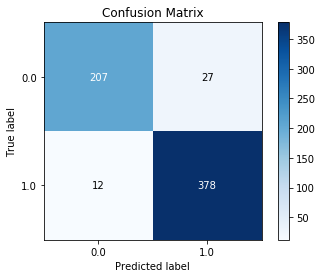

In [61]:
skplt.metrics.plot_confusion_matrix(np.array(test_actual), np.round(test_predict_proba));

In [64]:
print(classification_report(np.array(test_actual), np.round(test_predict_proba), target_names=['Normal', 'PNEUMONIA']))

              precision    recall  f1-score   support

      Normal       0.95      0.88      0.91       234
   PNEUMONIA       0.93      0.97      0.95       390

    accuracy                           0.94       624
   macro avg       0.94      0.93      0.93       624
weighted avg       0.94      0.94      0.94       624



- As we can see We got a very good recall rate of 0.97 on PNEUMONIA with a precision of 0.93.
- Normally in the medical test cases recall rate is very important, we should not label a pneumonia patient as normal which puts the person in danger.
- So by using our deep learning model we got a good recall rate as well as with good precision.
- our weighted average f1-score is 0.94 which is very good.

In [ ]:
#from IPython.display import FileLink
#FileLink('further_improved_cnn_model.h5')
#FileLink('best_cnn_weights.h5')